In [1]:
import torch, torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install opencv-python-headless

In [4]:
import zipfile
import os

# Path to the zip file (can be a path in your Colab environment or from your Drive)
zip_file_path = '/content/drive/MyDrive/Train_Spects.zip'

# Destination folder where the contents will be extracted
destination_folder = '/content/drive/MyDrive/Dataset/'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f'Contents extracted to {destination_folder}')


Contents extracted to /content/drive/MyDrive/Dataset/


In [111]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [112]:
train_folders = sorted(glob('/content/drive/MyDrive/Dataset/Train_Spects/*'))
len(train_folders)

7

In [113]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

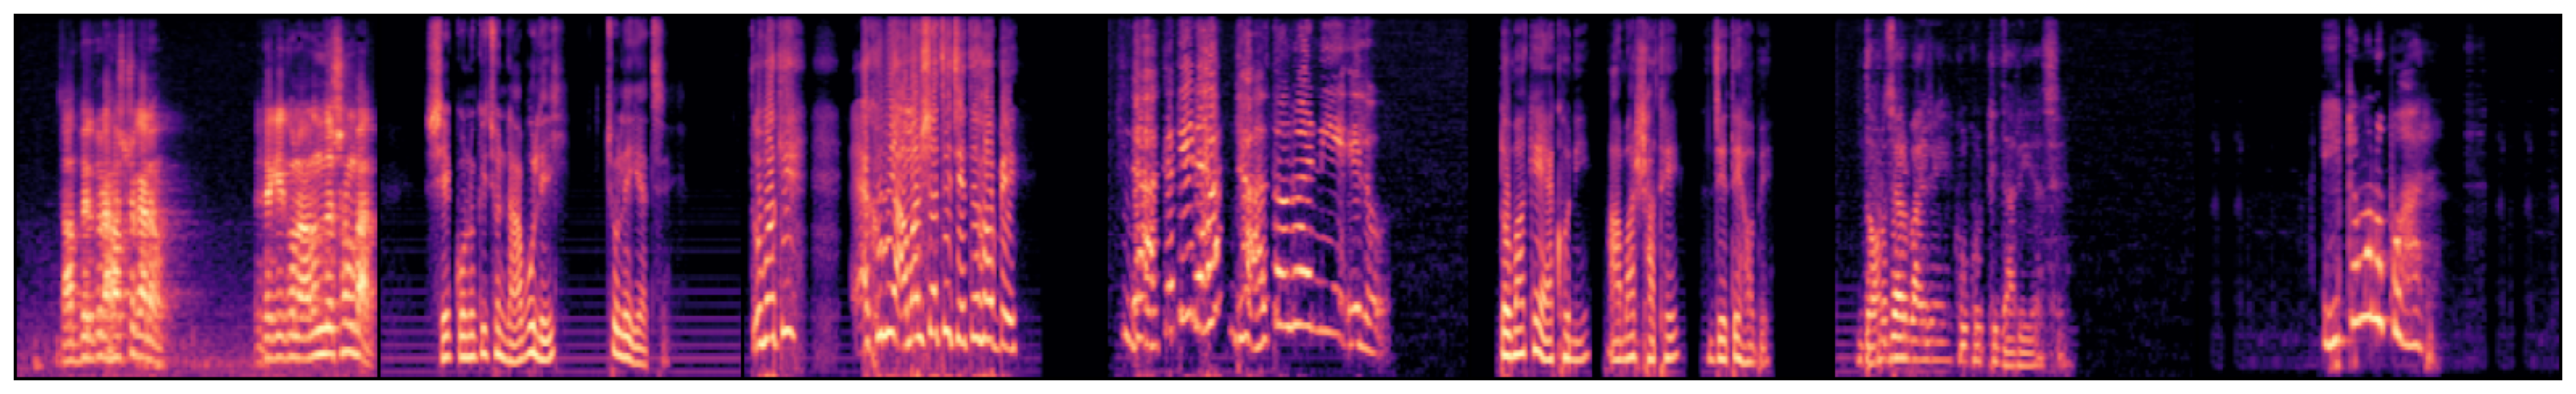

In [114]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

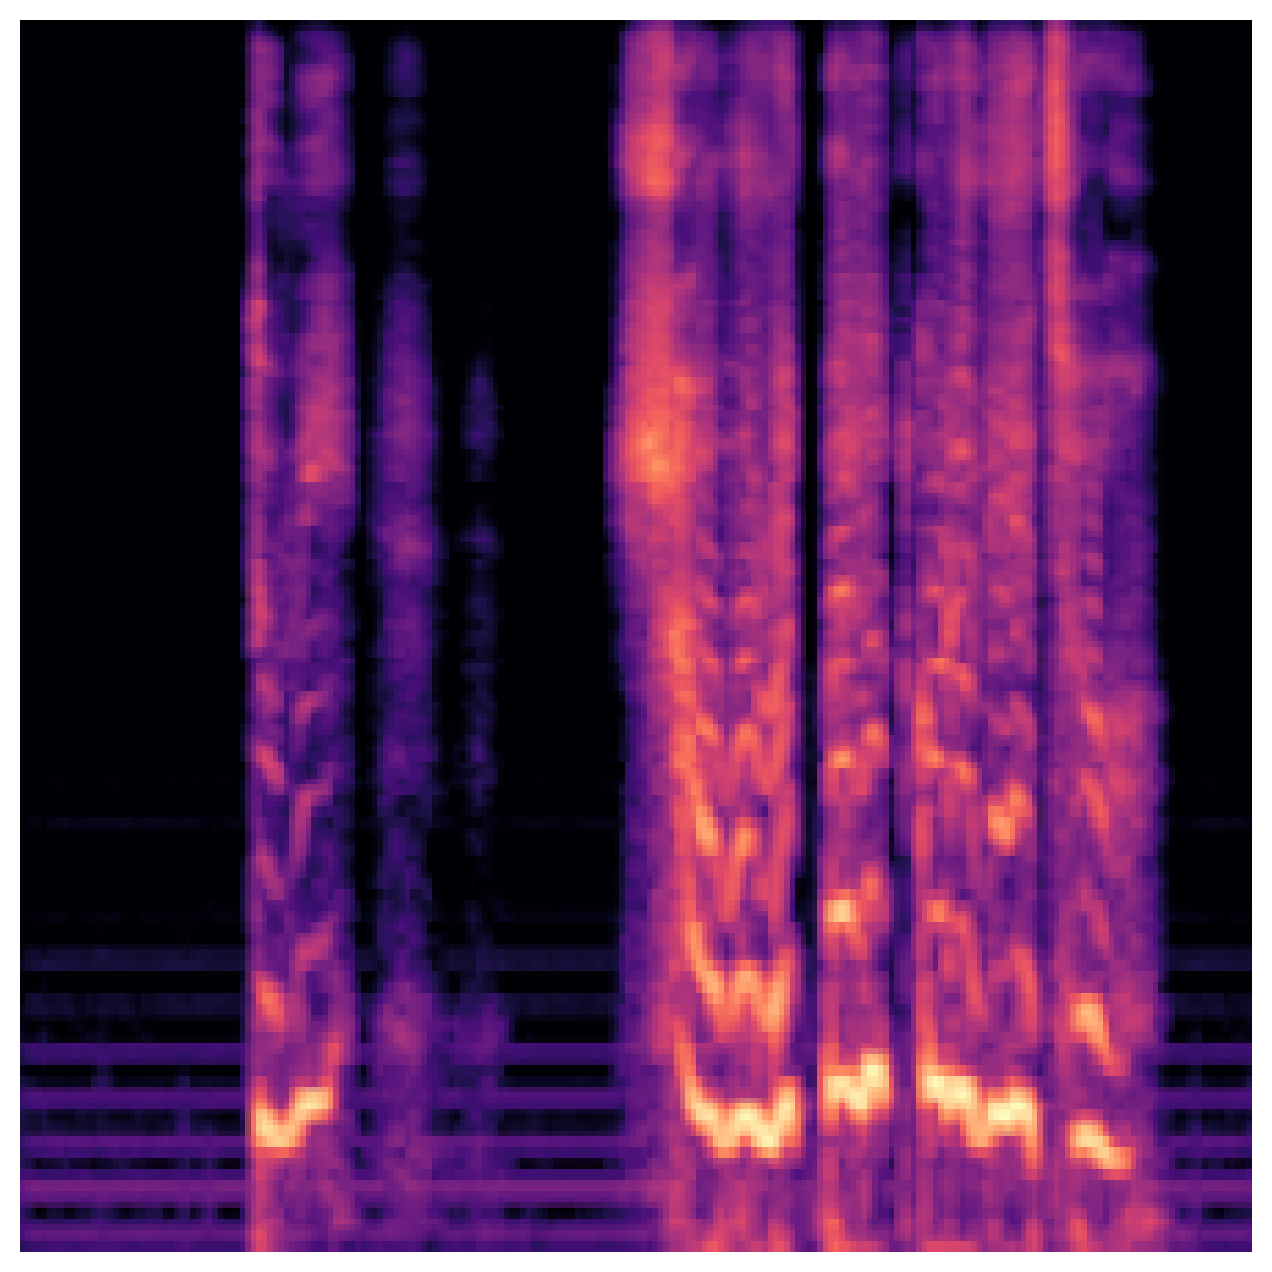

In [115]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [116]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [117]:
import subprocess
command = "rm -rf data"
subprocess.run(command, shell=True)

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [118]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths))] #Data Split Ratio here:
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 2710
Disgust: 2160
Fear: 1800
Happy: 2710
Neutral: 2416
Sad: 2710
Surprise: 2350


In [119]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [120]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=32, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [121]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 13484, 'val': 3372}

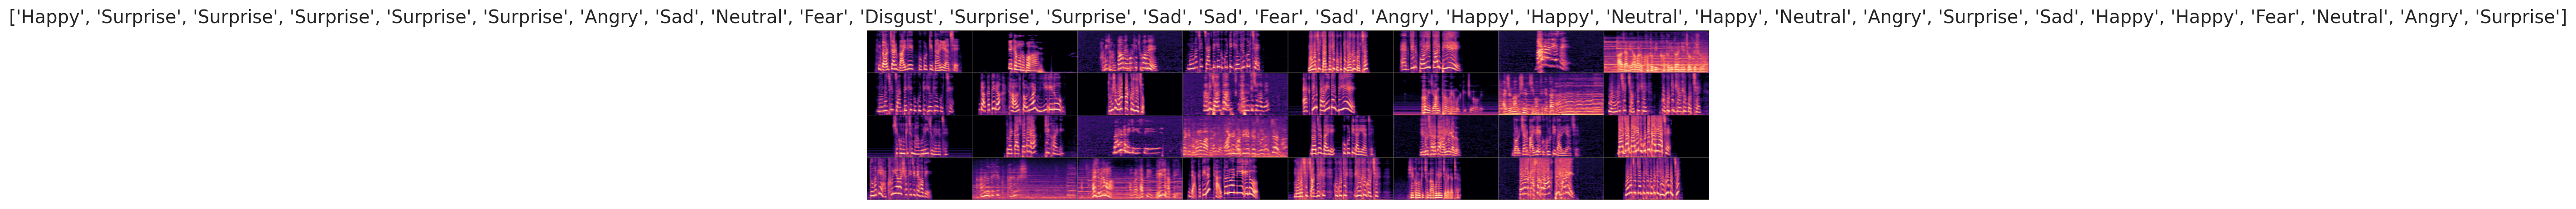

In [122]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [126]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out += identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5], device='cpu'):
    model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

    model.aux_logits = False
    model.aux1 = None
    model.aux2 = None

    in_features = 1024

    model.fc = nn.Sequential(
        nn.Flatten(),
        ResidualBlock(in_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [127]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 151MB/s]


In [128]:
#base_model.classifier[-1]

In [129]:
#IN_FEATURES = base_model.classifier[-1].in_features

#final_fc = nn.Linear(IN_FEATURES,len(class_names) )

In [130]:
#base_model.classifier[-1] = final_fc

In [131]:
print(base_model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [132]:
base_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [133]:
from tqdm.notebook import tqdm

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  batch_progress = tqdm(data_loader, desc='Training', leave=False)

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    batch_progress.set_postfix(loss=np.mean(losses), accuracy=(correct_predictions.double() / n_examples).item())
    batch_progress.update(1)
  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [134]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  batch_progress = tqdm(data_loader, desc='Evaluation', leave=False)
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      batch_progress.set_postfix(loss=np.mean(losses), accuracy=(correct_predictions.double() / n_examples).item())
      batch_progress.update(1)

  return correct_predictions.double() / n_examples, np.mean(losses)

In [135]:
#pip install tqdm

In [136]:
from tqdm import tqdm

def train_model(model, data_loaders, dataset_sizes, device, n_epochs=12): #Epoch
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [137]:
%%time
#224*224
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/12
----------


Train loss 1.7190502141889237 accuracy 0.302358350637793


Val   loss 1.3029045507592976 accuracy 0.4804270462633452

Epoch 2/12
----------


Train loss 1.1757397301389143 accuracy 0.5415307030554731


Val   loss 0.906136524002507 accuracy 0.6456109134045077

Epoch 3/12
----------


Train loss 0.8427243590072433 accuracy 0.6750222485909226


Val   loss 0.8077061305630882 accuracy 0.6936536180308422

Epoch 4/12
----------


Train loss 0.6137235225376925 accuracy 0.7726194007712845


Val   loss 0.6206069228784094 accuracy 0.7674970344009491

Epoch 5/12
----------


Train loss 0.4390648986208495 accuracy 0.8380302580836547


Val   loss 0.5333448929606743 accuracy 0.8090154211150653

Epoch 6/12
----------


Train loss 0.2952780709977116 accuracy 0.8975081578166717


Val   loss 0.559091364999987 accuracy 0.8104982206405694

Epoch 7/12
----------


Train loss 0.23059209414991721 accuracy 0.9179026994956987


Val   loss 0.5259705474775918 accuracy 0.8336298932384342

Epoch 8/12
----------


Train loss 0.12361682034914175 accuracy 0.9587659448234945


Val   loss 0.4071388650193529 accuracy 0.8730723606168447

Epoch 9/12
----------


Train loss 0.09038114029984762 accuracy 0.9729308810442006


Val   loss 0.39735974244913963 accuracy 0.8760379596678529

Epoch 10/12
----------


Train loss 0.07601493363206879 accuracy 0.9768614654405221


Val   loss 0.39544993097770886 accuracy 0.8736654804270463

Epoch 11/12
----------


Train loss 0.07129964306818154 accuracy 0.9770097893800059


Val   loss 0.3920688641099435 accuracy 0.8760379596678529

Epoch 12/12
----------


Train loss 0.05827903453816805 accuracy 0.9827944230198754


Val   loss 0.39916346672008624 accuracy 0.8787069988137605

Best val accuracy: 0.8787069988137605
CPU times: user 14min 43s, sys: 2min 12s, total: 16min 55s
Wall time: 1h 2min 38s


In [138]:
checkpoint_path = "/content/drive/MyDrive/GOOGLENET.pth"
torch.save(base_model.state_dict(), checkpoint_path)

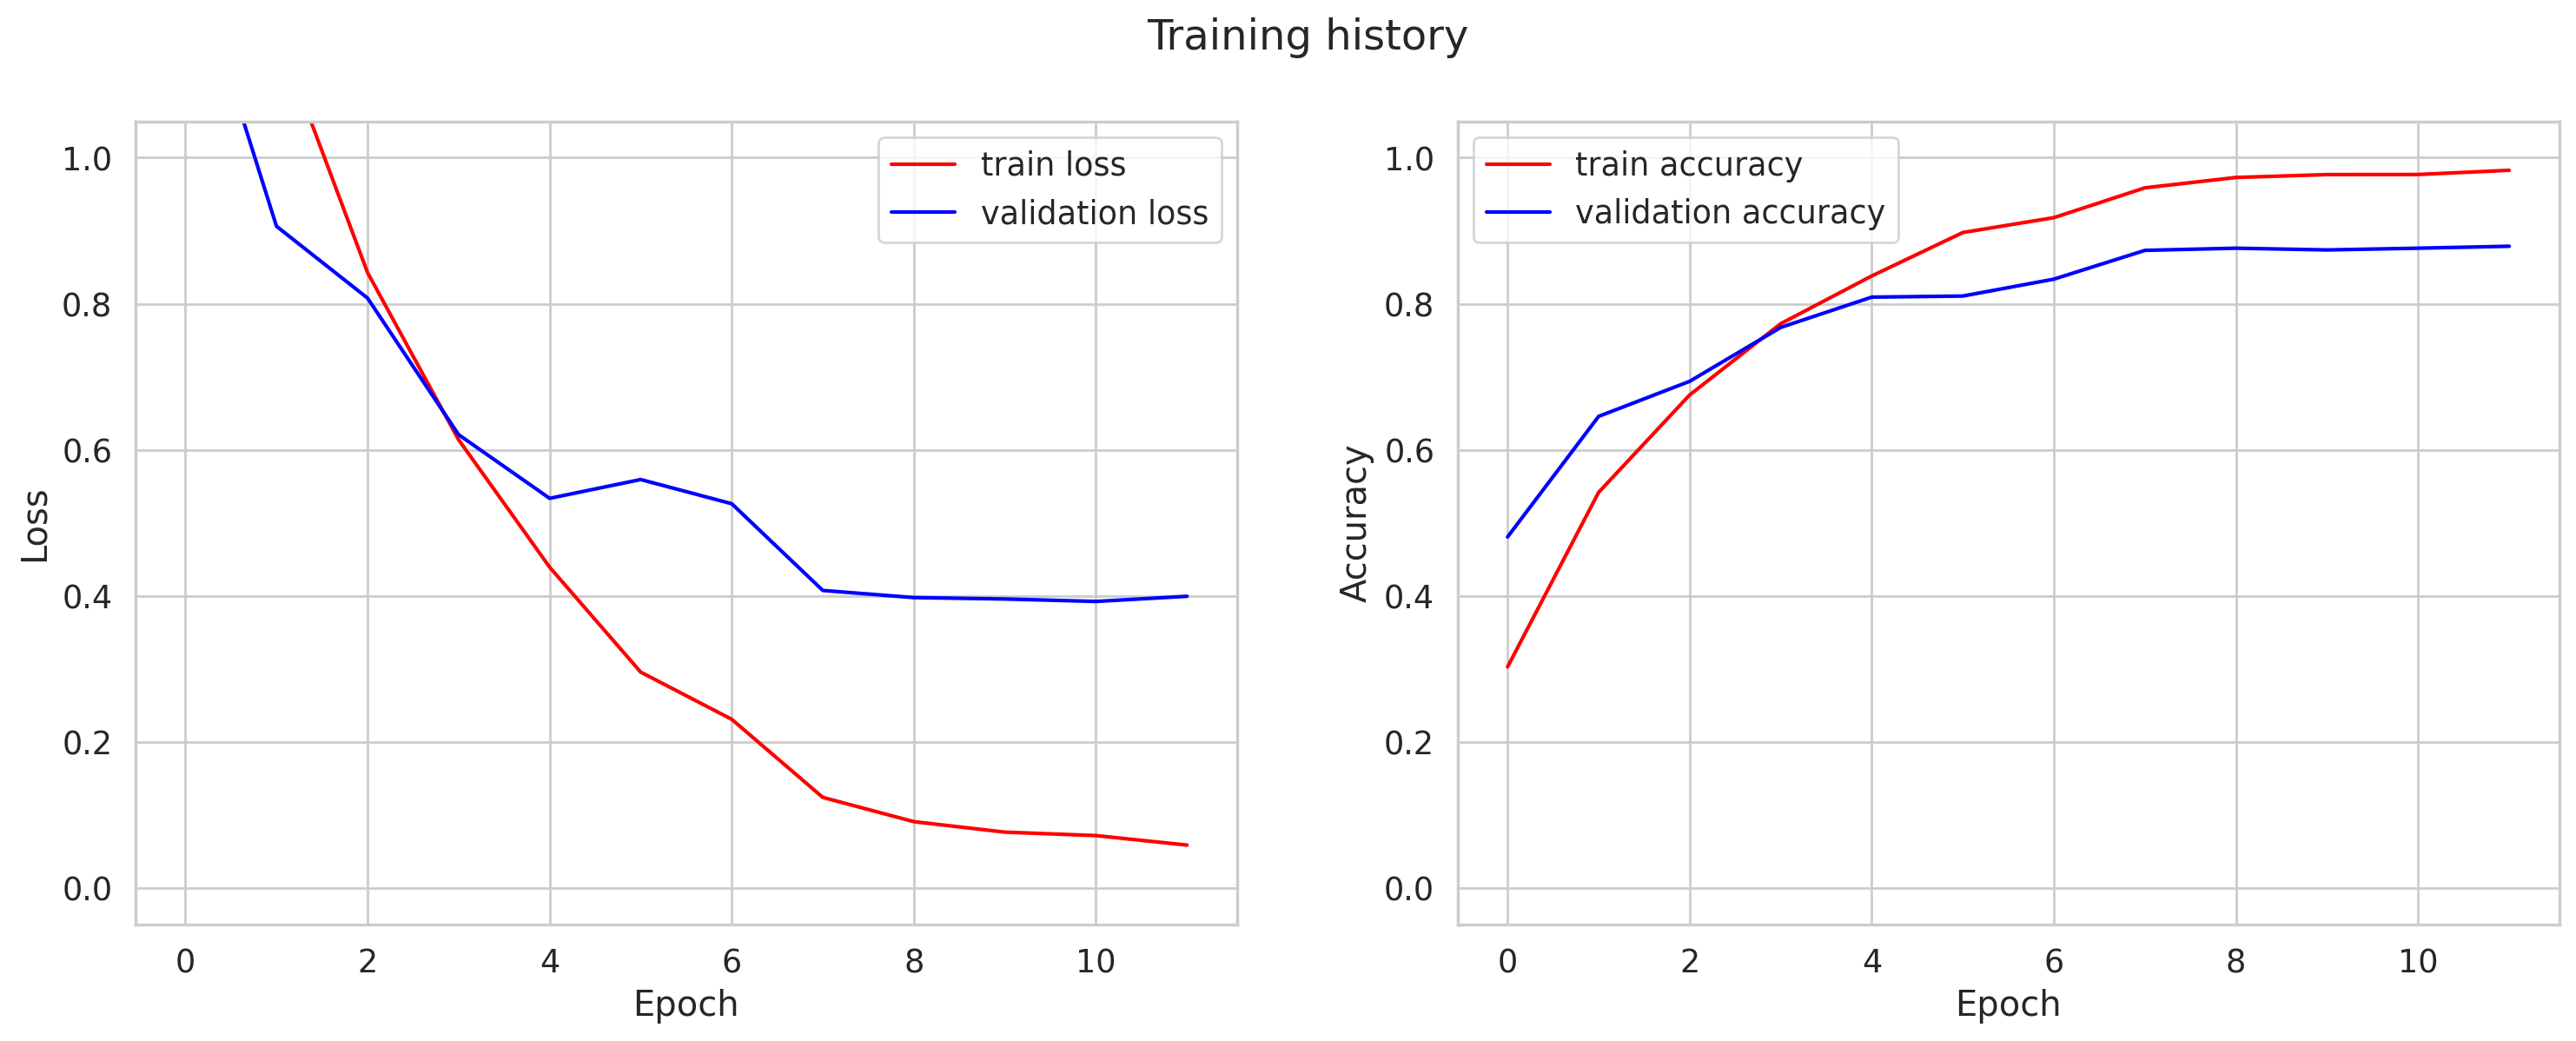

In [139]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history['train_loss'], label='train loss', color ='red')
    ax1.plot(history['val_loss'], label='validation loss', color = 'blue')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    # Move the tensors to the CPU and convert to NumPy arrays
    train_acc = [x.cpu().numpy() for x in history['train_acc']]
    val_acc = [x.cpu().numpy() for x in history['val_acc']]
    # train_acc = [x for x in history['train_acc']]
    # val_acc = [x for x in history['val_acc']]

    ax2.plot(train_acc, label='train accuracy',color ='red')
    ax2.plot(val_acc, label='validation accuracy',color ='blue')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')

plot_training_history(history)

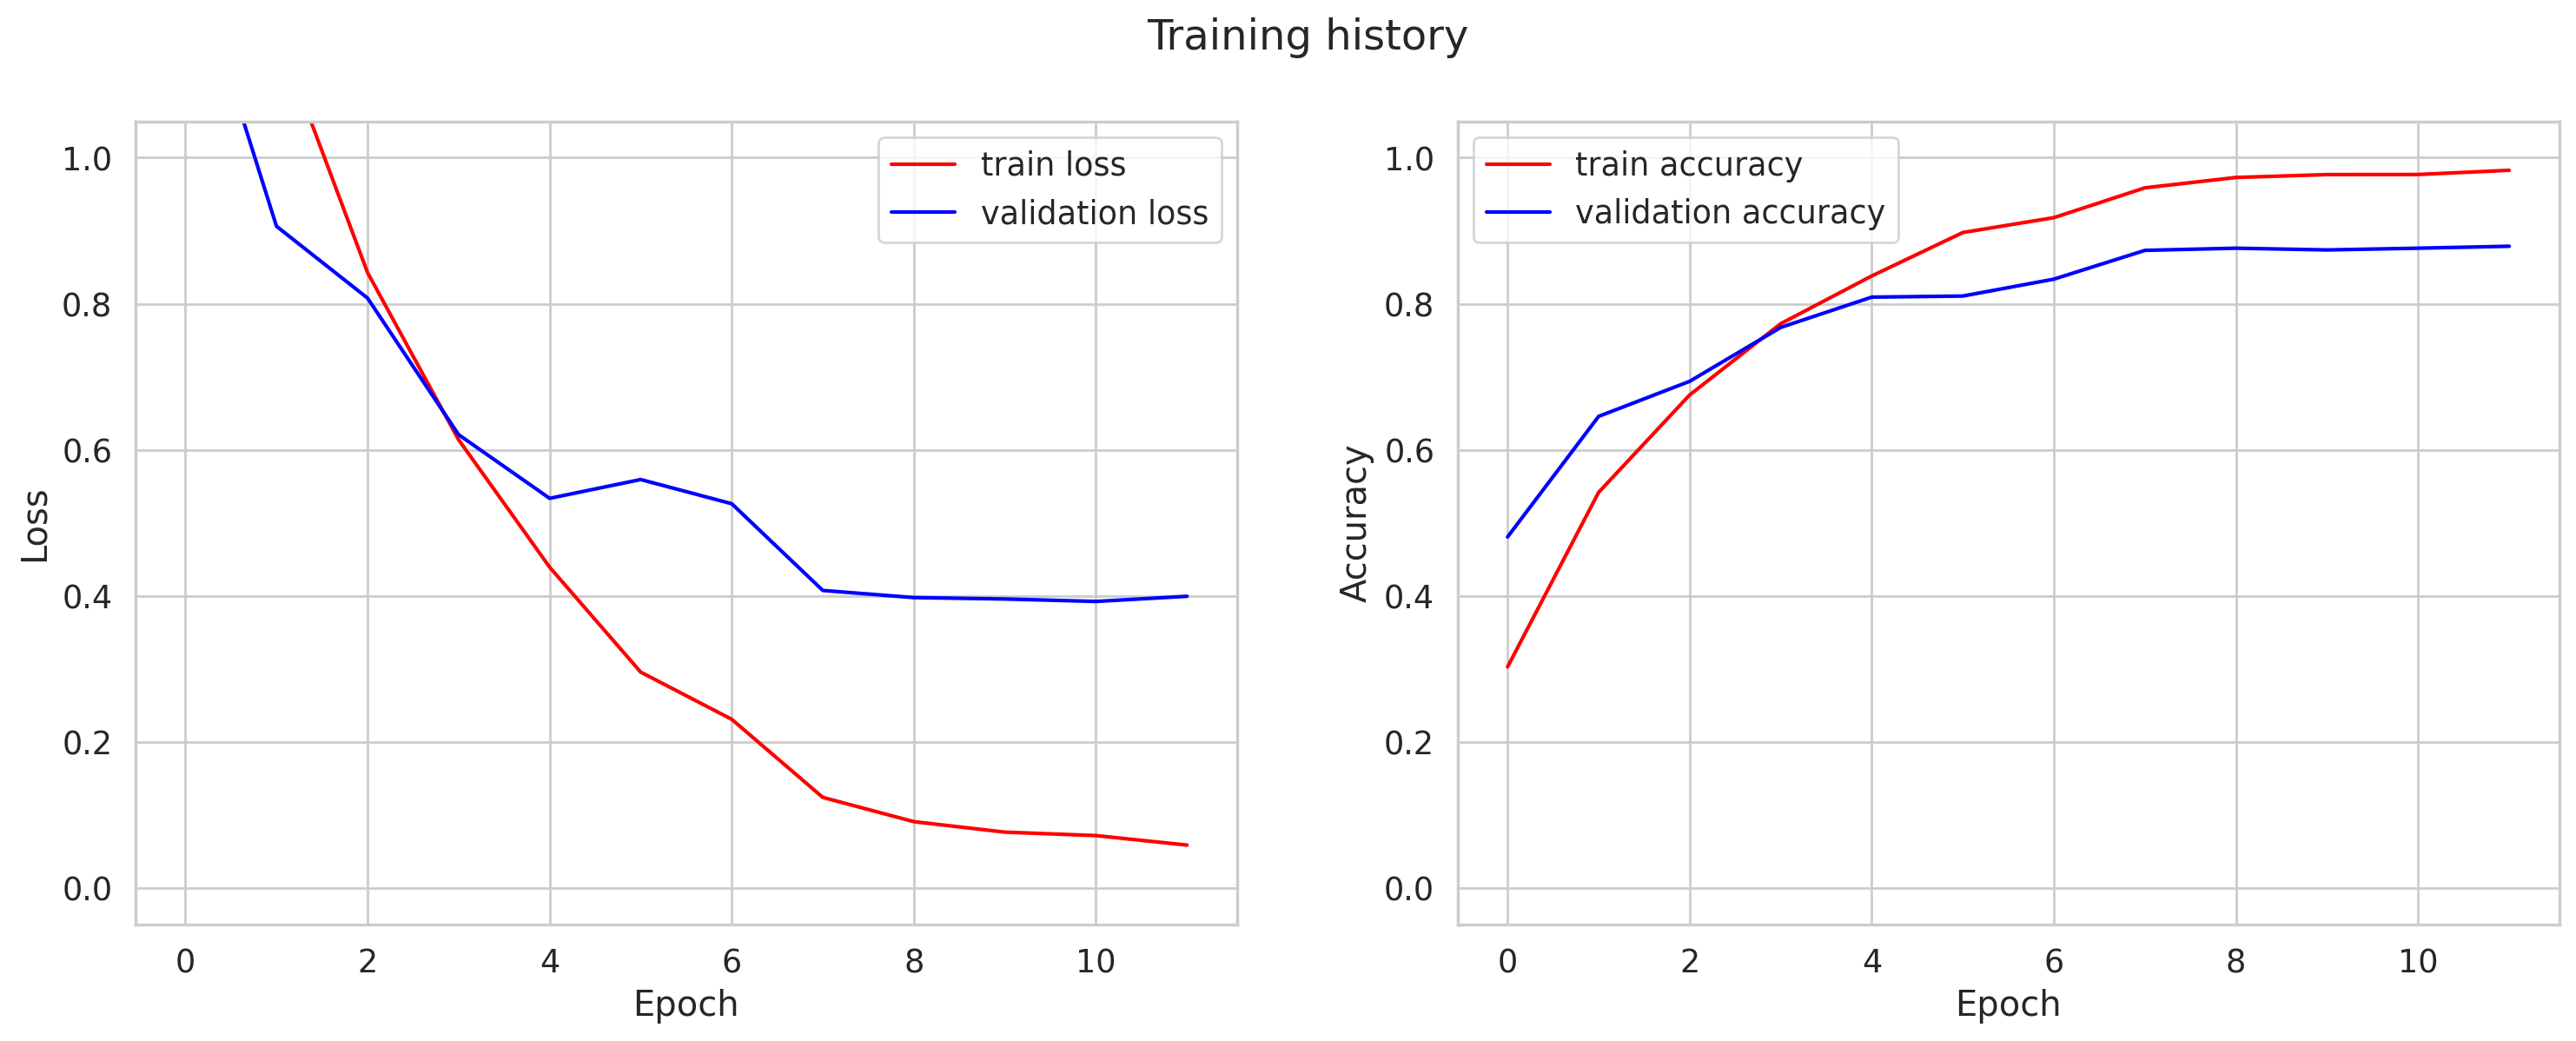

In [140]:
#224*224
plot_training_history(history)

# **Test Data**(unseen)

In [141]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

In [142]:
test_folders = sorted(glob('/content/drive/MyDrive/Dataset/Test_Spects/*'))
len(test_folders)
#E:/Thesis/Seg2_test_set_classified/0-25/* done
#E:/Thesis/Seg2_test_set_classified/25-50/* done
#E:/Thesis/Seg2_test_set_classified/50plus/* done
#E:/Thesis/Seg2_test_set/*

7

In [143]:
base_model = create_model(len(class_names))
#base_model.classifier[-1]
#IN_FEATURES = base_model.classifier[-1].in_features

#final_fc = nn.Linear(IN_FEATURES,len(class_names) )
#base_model.classifier[-1] = final_fc
#print(base_model.classifier)

checkpoint_path = "/content/drive/MyDrive/GOOGLENET.pth"
checkpoint = torch.load(checkpoint_path)

base_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
base_model.to(device)
base_model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [144]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

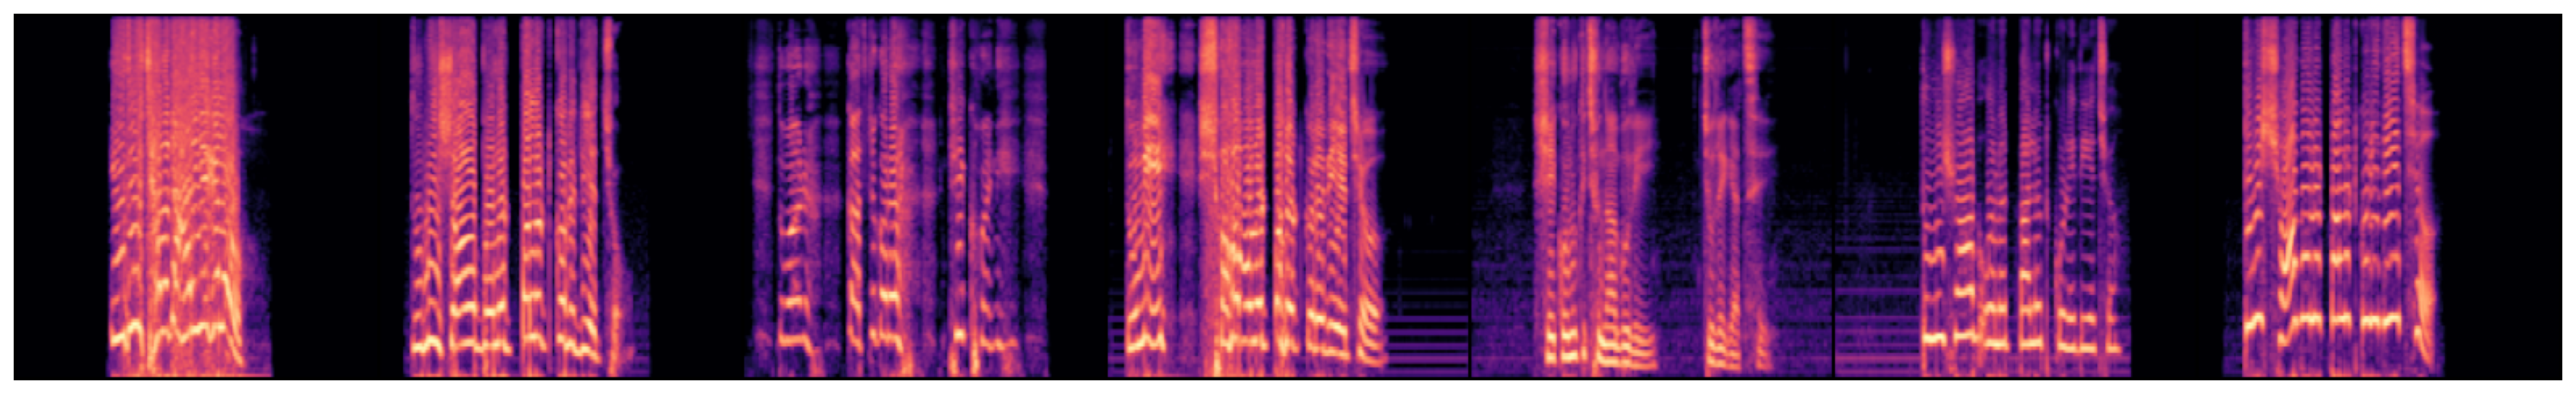

In [145]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

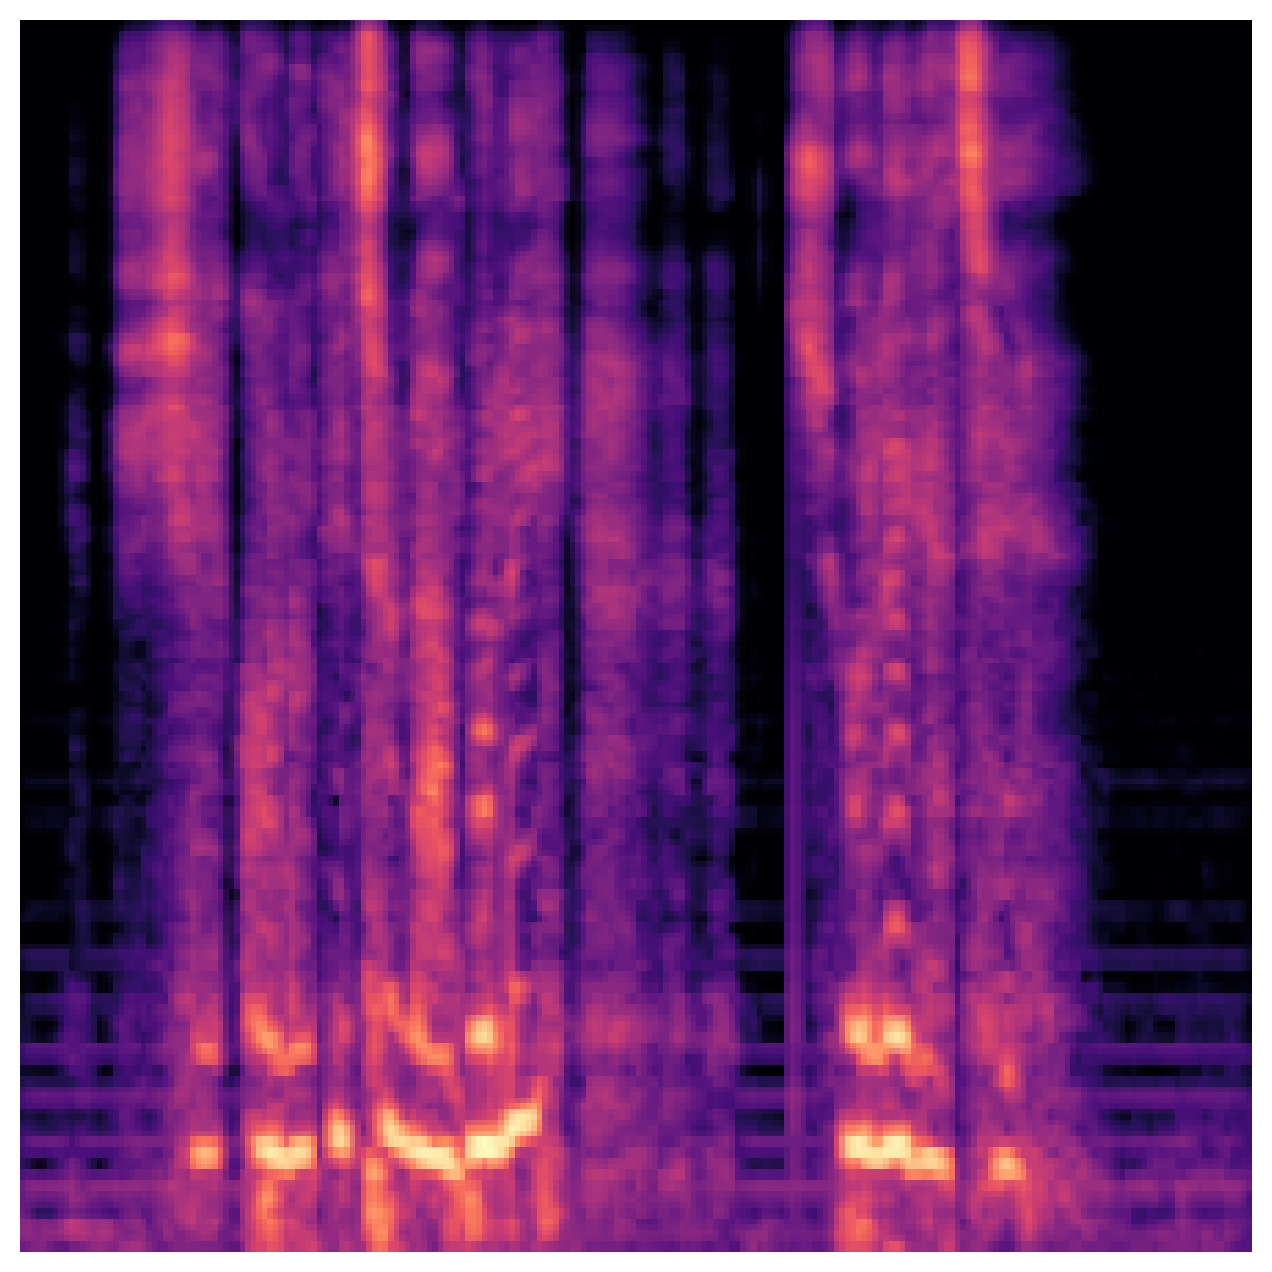

In [146]:
img_path = glob(f'{test_folders[2]}/*png')[1]

show_image(img_path)

In [147]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [148]:
import subprocess
command = "rm -rf data"
subprocess.run(command, shell=True)

DATA_DIR = Path('test_data')

DATASETS = ['test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [149]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 151
Disgust: 120
Fear: 100
Happy: 151
Neutral: 135
Sad: 151
Surprise: 131


In [150]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [151]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [152]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 939}

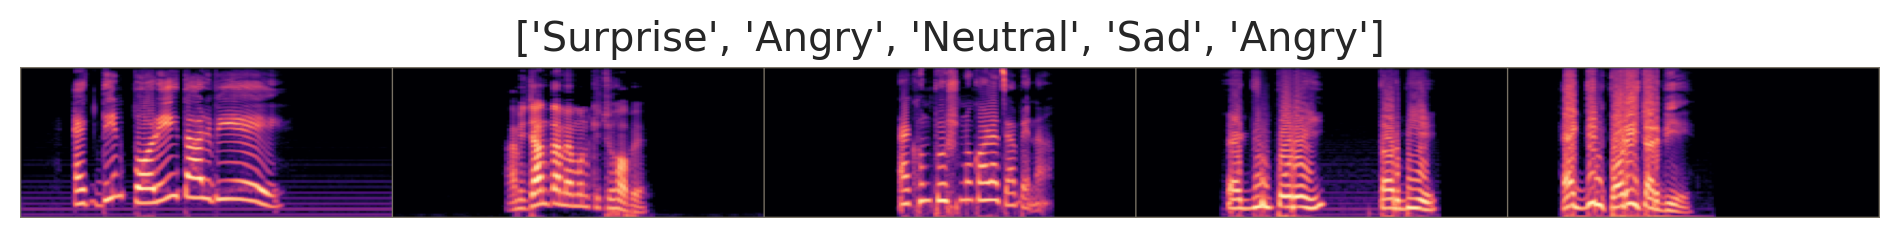

In [153]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [154]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

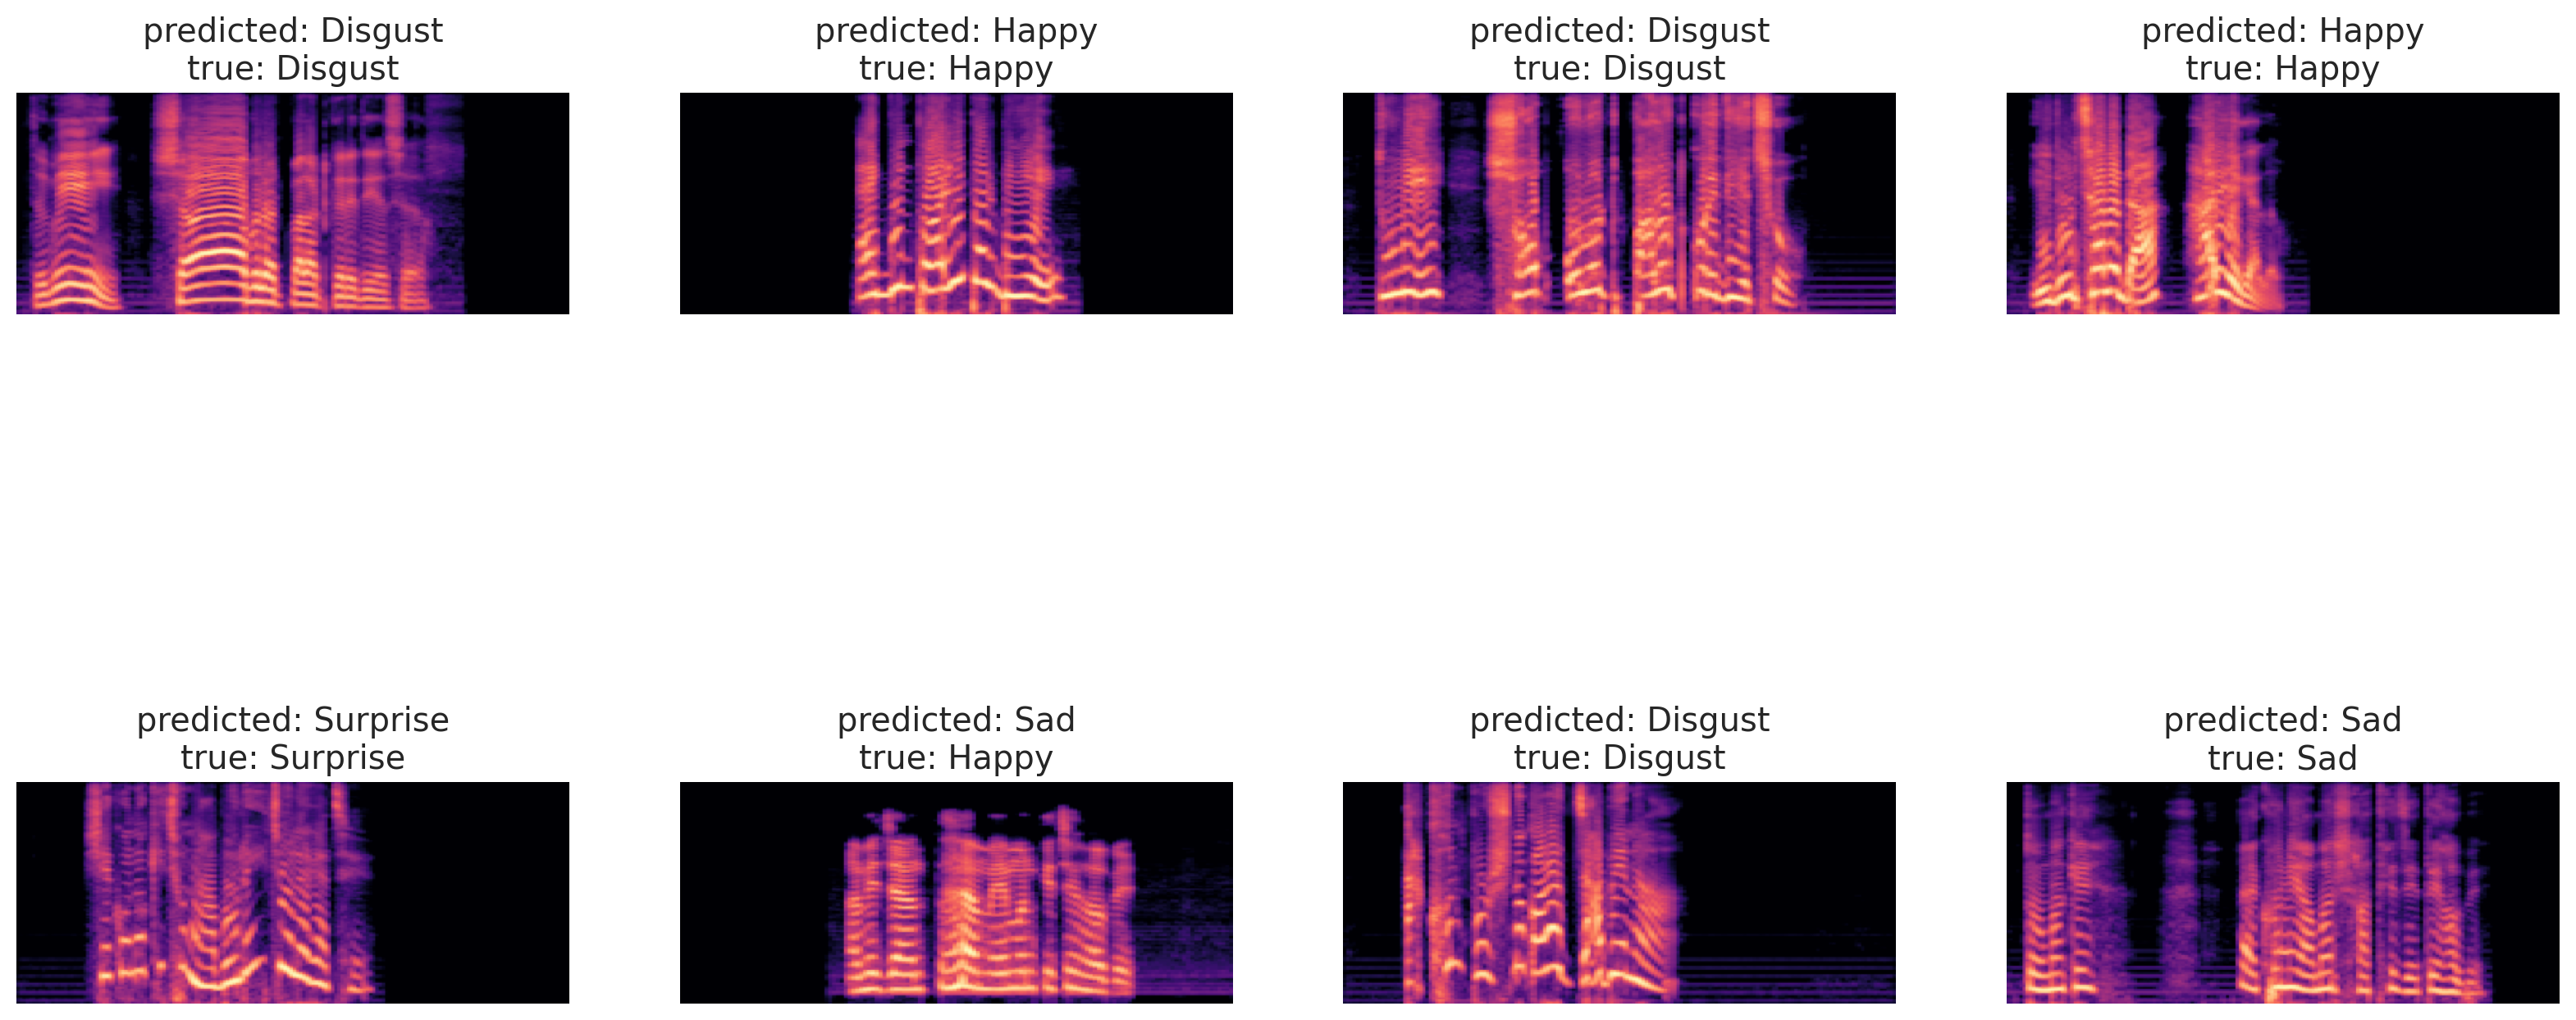

In [155]:
show_predictions(base_model, class_names, n_images=8)

In [156]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [157]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [158]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.89      0.87      0.88       151
     Disgust       0.79      0.75      0.77       120
        Fear       0.94      0.89      0.91       100
       Happy       0.76      0.81      0.78       151
     Neutral       0.89      0.94      0.91       135
         Sad       0.87      0.84      0.86       151
    Surprise       0.89      0.90      0.89       131

    accuracy                           0.86       939
   macro avg       0.86      0.86      0.86       939
weighted avg       0.86      0.86      0.86       939



In [159]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

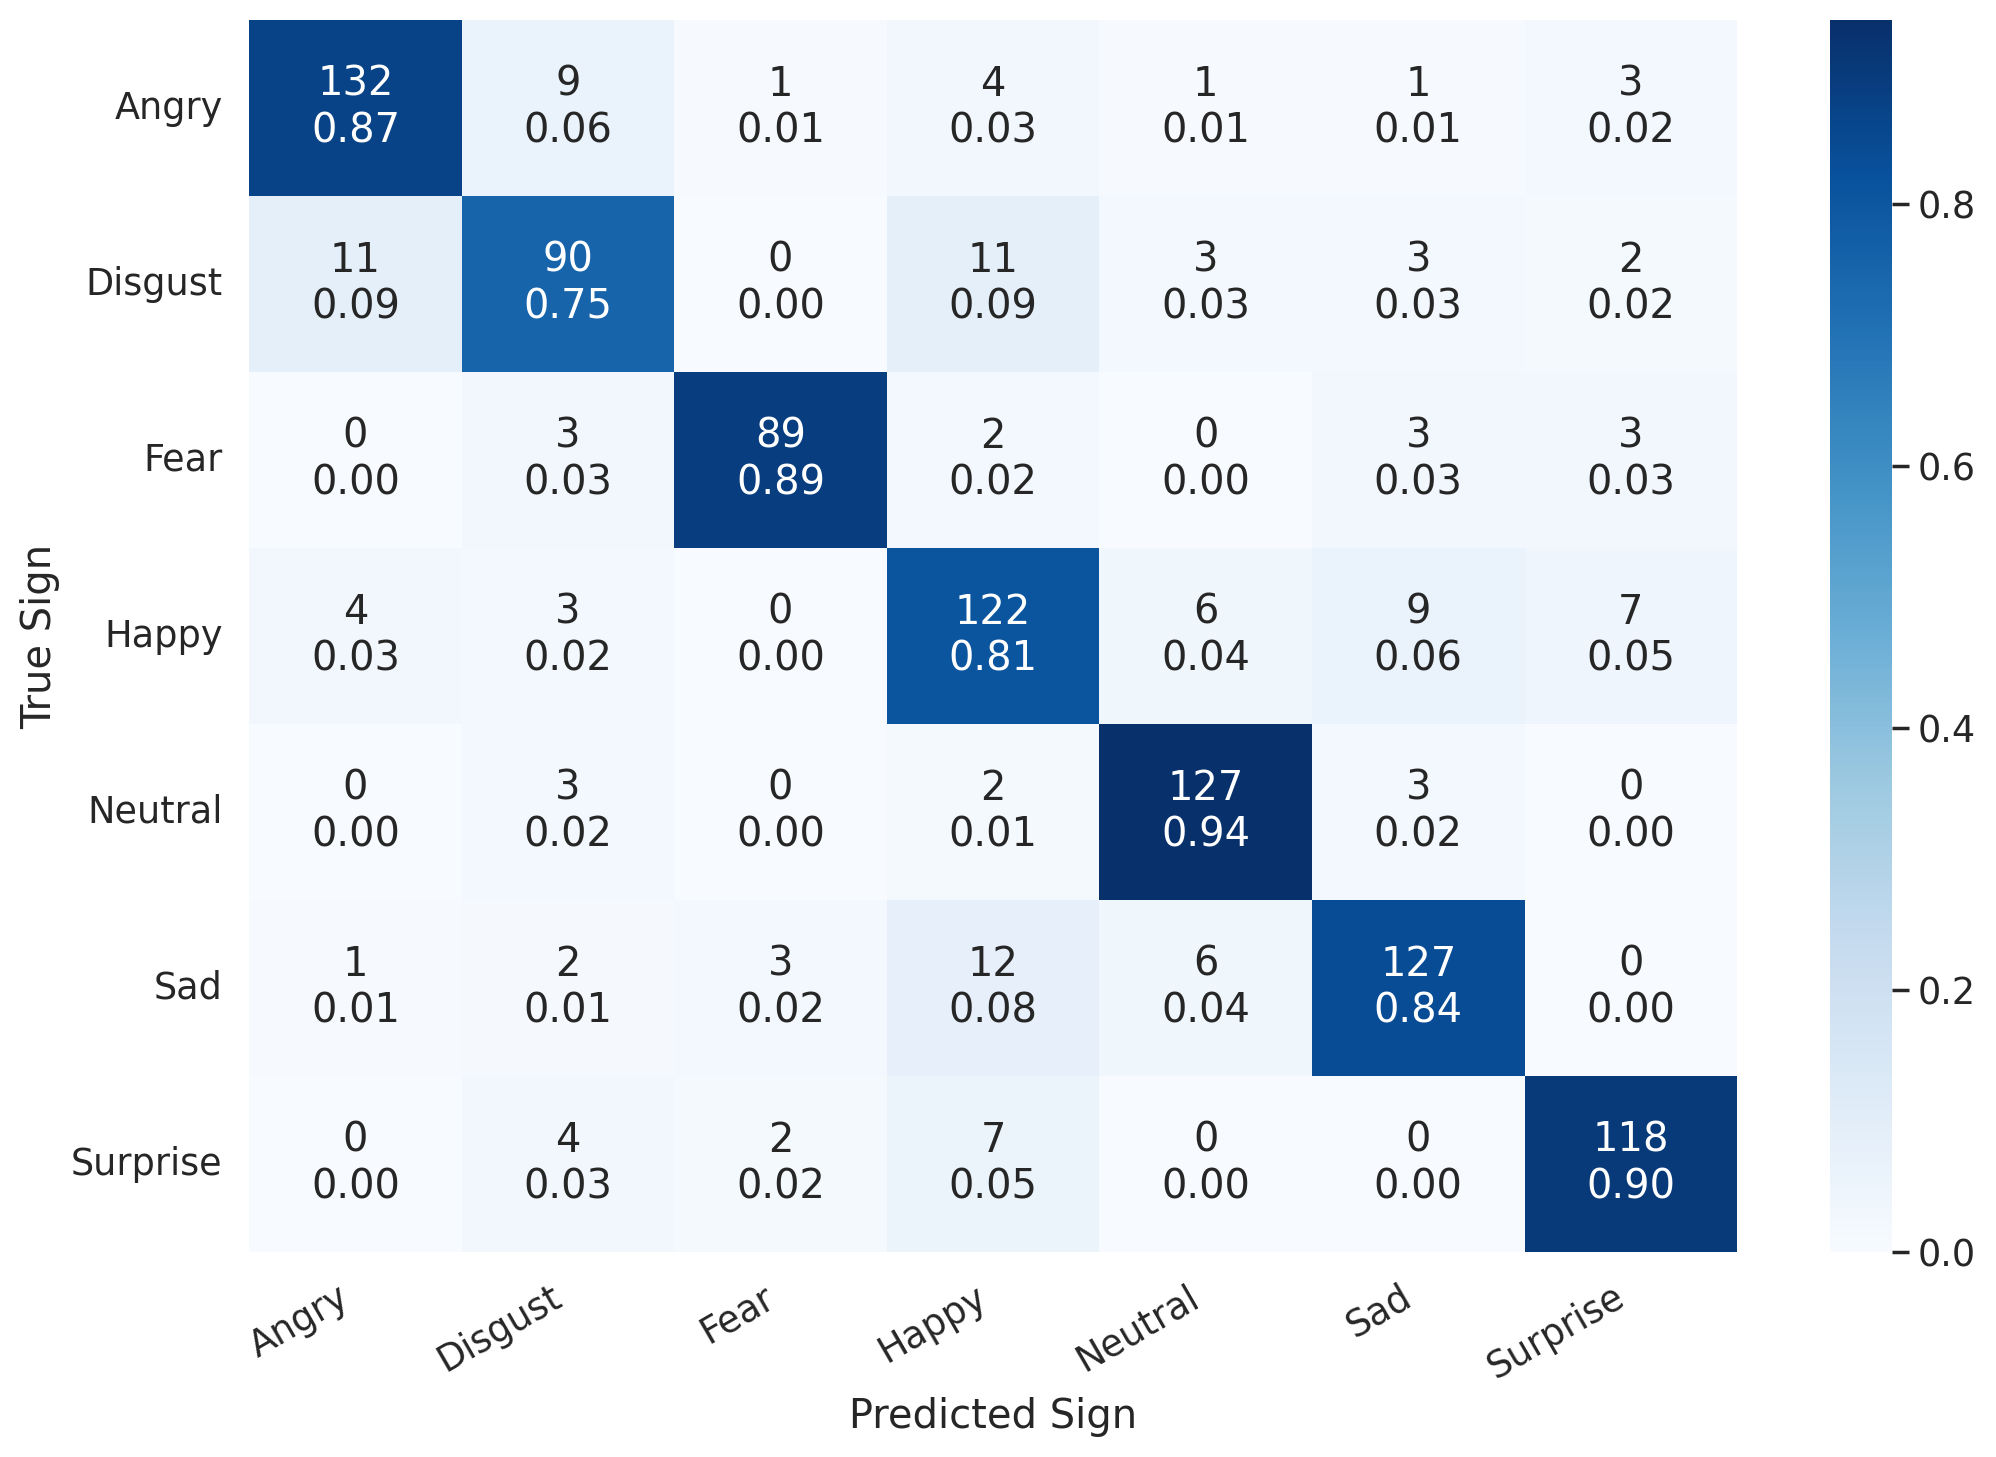

In [160]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)